# Straight-ray time-of-flight inversion

In this notebook, the time-of-flight shifts computed from the random wavefield phase weighted correlation stacks are used in a 2D straight-ray time-of-flight tomographic inversion in order to reconstruct the speed-of-sound map of the tissue mimicking phantom. In the following notebook, we set up a computational domain using a rectilinar grid, construct the straight-ray-tracing matrix and then solve the regularized inverse problem using *damped least-squares* and a *second order Tikhonov regularization*.

### Python dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import linalg
from tqdm import trange
import itertools
import straight_ray_tomo
import xarray as xr
from grid import *

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size": 25})
plt.rcParams["xtick.major.pad"] = "15"
plt.rcParams["ytick.major.pad"] = "15"

### Utility functions

In [2]:
def plot_model(m, g, title=None, caxis=None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    if not title == None:
        ax.set_title(title)

    plt.imshow(
        np.reshape(m, [g.x.shape[0], g.y.shape[0]]).T,
        extent=[
            g.x[0],
            g.x[0] + g.x.shape[0] * g.spacing,
            g.y[0],
            g.y[0] + g.y.shape[0] * g.spacing,
        ],
        cmap="gray",
    )
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    if caxis is not None:
        plt.clim(caxis)
    plt.colorbar(label="s [s/m]")

In [3]:
def plot_Lcurve(x_vals, y_vals, reg_param, title, a, secondTikhonov=False):
    colors = itertools.cycle(["gold", "orange", "red", "blueviolet"])
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(111)
    for i in range(len(x_vals)):
        if i in a:
            ax.plot(
                x_vals[i],
                y_vals[i],
                "o",
                label="$\\alpha$ = %.2f" % reg_param[i],
                color=next(colors),
                markersize=10,
            )
            ax.plot(x_vals[i], y_vals[i], "ko", fillstyle="none", markersize=10)
            ax.legend()
        else:
            ax.plot(x_vals[i], y_vals[i], "ko", fillstyle="none", markersize=10)
            ax.set_xlabel(
                "residual norm ||$\\mathbf{G}\\mathbf{m}_\\alpha-\\mathbf{d}$||$_2$",
                labelpad=15,
            )
            if secondTikhonov:
                ax.set_ylabel(
                    "solution norm ||$\\nabla^2\\mathbf{m}_\\alpha$||$_2$", labelpad=15
                )
            else:
                ax.set_ylabel(
                    "solution norm ||$\\mathbf{m}_\\alpha$||$_2$", labelpad=15
                )
        ax.set_title(title, pad=20)
    ax.grid()
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

## 1. Set up the geometry
### 1.1 Sources and receivers

In [4]:
nrec = 256  # number of receivers
reccoo = np.load("data/reccoo.npy")

### sources and receivers coincide
srccoo = np.copy(reccoo)
sources, receivers = straight_ray_tomo.get_all_to_all_locations(srccoo, reccoo)

### 1.2 Computational domain and rectilinear grid

Here, we set up the rectilinear grid.

In [5]:
spacing = 0.0008
min_x = min(np.min(sources[:, 0]), np.min(receivers[:, 0]))
min_y = min(np.min(sources[:, 1]), np.min(receivers[:, 1]))
max_x = max(np.max(sources[:, 0]), np.max(receivers[:, 0]))
max_y = max(np.max(sources[:, 1]), np.max(receivers[:, 1]))

npoints = np.array(
    [int(np.ceil((max_x - min_x) / spacing)), int(np.ceil((max_y - min_y) / spacing))]
)

g = xr.Dataset(
    coords={
        "x": np.linspace(min_x, max_x, npoints[0], endpoint=True),
        "y": np.linspace(min_y, max_x, npoints[1], endpoint=True),
        "spacing": spacing,
    },
)

### 1.3 Compute straight-ray-tracing forward operator

Next, we set up the straight-ray-tracing matrix $\mathbf{G}$ that we need later in the inversions. $\mathbf{G}$ connects a slowness model $\mathbf{m}$ to our observed time-of-flight shifts $\mathbf{d}$. The number of rows of $\mathbf{G}$ is equal to the number of data points, thus to the number of rays that connect all source receiver pairs. The number of columns of $\mathbf{G}$ is equal to the unknowns in model space and thus to the number of pixels defined by the computational grid.

In [6]:
G = straight_ray_tomo.create_forward_operator(sources, receivers, g)
print("Matrix shape:            ", G.shape)
print("Data points:             ", G.shape[0])
print("Unknowns in model space: ", G.shape[1])
print("Non-zero entries:        ", G.count_nonzero())
print(
    "Ratio of non-zeros: {:10.4f} %".format(
        100 * G.count_nonzero() / (G.shape[0] * G.shape[1])
    )
)

straight_ray_tomo.plot_ray_density(G, g)

Matrix shape:             (65536, 50625)
Data points:              65536
Unknowns in model space:  50625
Non-zero entries:         11955460
Ratio of non-zeros:     0.3603 %


(<Figure size 432x432 with 2 Axes>,
 <AxesSubplot:title={'center':'spacing = 0.0008'}, xlabel='x [m]', ylabel='y [m]'>)

## 2. Inverse Problem setup
With the next lines, we will set up the linearized inverse problem that allows us to reconstruct the speed-of-sound map of the tissue mimicking phantom.

### 2.1 Initialize homogeneous background medium
As a prior in model space, we chose a homogeneous model with slowness values being equal to that of water (s=1/1500 s/m).

In [7]:
prior = 1500 * np.ones(npoints)
g["soundspeed"] = (["x", "y"], prior)
m_prior = (1 / np.array(g.data_vars["soundspeed"])).ravel()

plot_model(m_prior, g, "prior model (slowness [s / m])")

### 2.2 Load the observed data: correlation time-of-flight sifts

In [8]:
tof_shifts = np.load("data/tof_shifts.npy")
### check that we have corresponding sizes
print(tof_shifts.shape, G.shape)

(65536,) (65536, 50625)


Let's plot the data to get an overview.

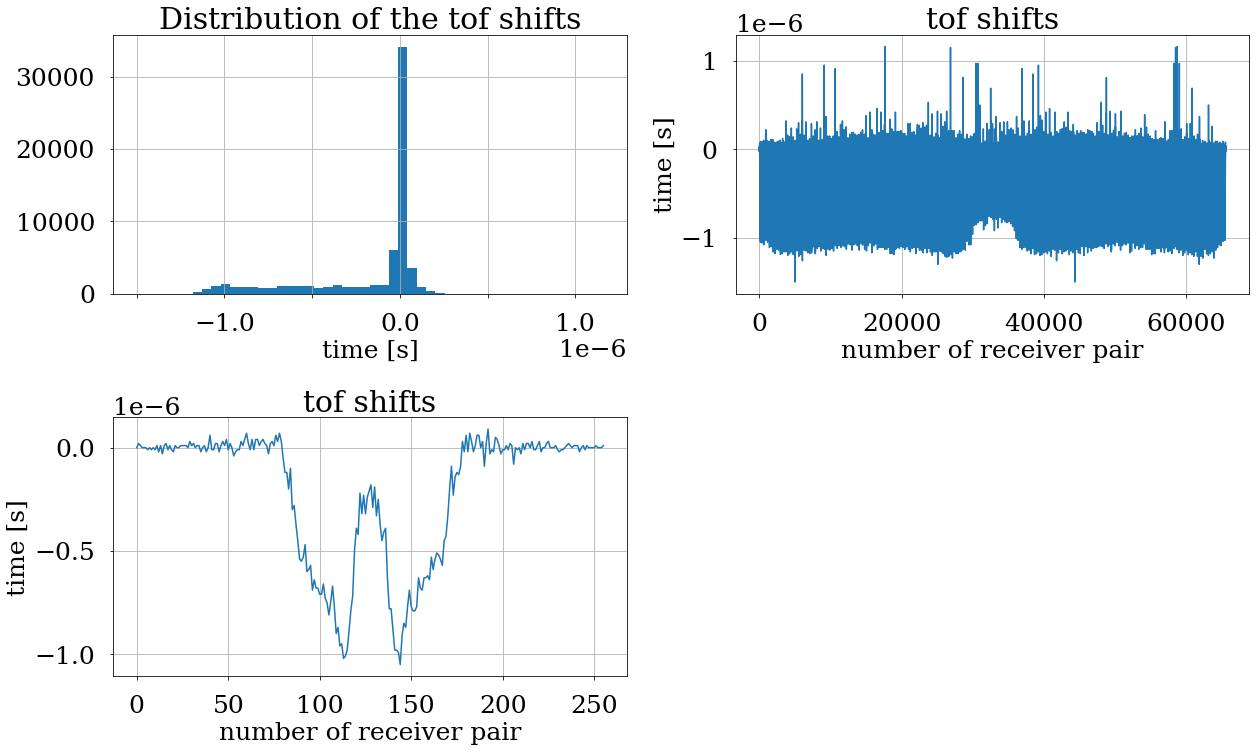

In [9]:
fig = plt.figure(figsize=(18, 11))
ax1 = plt.subplot(221)
n, bins, patches = ax1.hist(tof_shifts, 50)
every_nth = 2
for m, label in enumerate(ax1.xaxis.get_ticklabels()):
    if m % every_nth != 0:
        label.set_visible(False)
        ax1.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
ax1.grid()
ax1.set_xlabel("time [s]")
ax1.set_title("Distribution of the tof shifts")

ax2 = plt.subplot(222)
ax2.plot(tof_shifts)
ax2.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax2.grid()
ax2.set_xlabel("number of receiver pair")
ax2.set_ylabel("time [s]")
ax2.set_title("tof shifts")

ax3 = plt.subplot(223)
ax3.plot(tof_shifts[:nrec])
ax3.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax3.grid()
ax3.set_xlabel("number of receiver pair")
ax3.set_ylabel("time [s]")
ax3.set_title("tof shifts")

fig.tight_layout()

## 3. Solve regularized least-squares Problem: **Damped least-squares**
In the following, we use a least-squares procedure that solves the linearized inverse problem
$$\min_{\mathbf{m}}\frac{1}{2}||\mathbf{G}\mathbf{m}-\mathbf{d}||_2^2+\alpha||\mathbf{m}||^2_2,$$
where $\mathbf{G}$ is the straight-ray-tacing forward matrix, $\mathbf{m}$ the model parametrized in slowness, $\mathbf{d}$ our observed time-of-flight shifts and $\alpha$ the regularization damping. With this, we obtain a reconstruction the slowness structure of the tissue. To tune the amount of prior information that is injected into the problem via the regularization term, we use an L-curve plot to visualize the contribution of the solution and the residual norm. Note that the regularization weight can be adjusted in `linalg.lsmr()` with the `damp` argument.

### 3.1 Tuning the regularization weight: L-curve plots

In [10]:
def L_curve_dampedLS(G, d, reg_param, m_prior):
    x_values = np.zeros(len(reg_param))
    y_values = np.zeros(len(reg_param))
    for i in trange(len(reg_param)):
        solution = scipy.sparse.linalg.lsmr(
            G, d, maxiter=600, show=False, damp=reg_param[i], atol=1e-8
        )
        m_rec_wf = m_prior - solution[0]
        x_values[i] = -np.linalg.norm(G.dot(m_rec_wf) - d)
        y_values[i] = np.linalg.norm(m_rec_wf - m_prior)
    return x_values, y_values

In [11]:
reg_param = np.linspace(0.008, 0.3, 50)  # select a range of damping values to test
### for CI testing
b = 1
### to reproduce figures
# b = reg_param.shape[0]

x_values_dampedLS, y_values_dampedLS = L_curve_dampedLS(
    G, tof_shifts, reg_param[:b], m_prior
)

100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


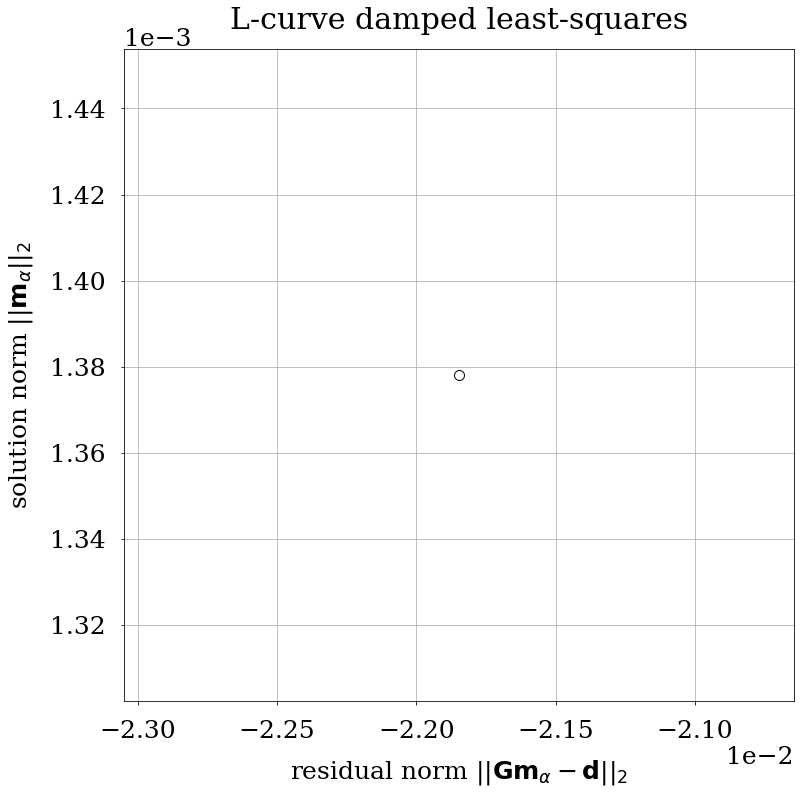

In [12]:
a = [2, 4, 6, 11]  # selected regularisation weigths are represented by colored dots
plot_Lcurve(
    x_values_dampedLS, y_values_dampedLS, reg_param, "L-curve damped least-squares", a
)

### 3.2 Invert for the phantom structure: **Damped least-squares**
Finally, we are ready to invert for the speed-of-sound structure using the damping values we select from the L-curve plot.

In [13]:
solution = linalg.lsmr(
    G, tof_shifts, maxiter=600, show=True, damp=reg_param[11], atol=1e-12
)
m_rec_wf_dampedLS = m_prior - solution[0]

 
LSMR            Least-squares solution of  Ax = b

The matrix A has 65536 rows and 50625 columns
damp = 7.35510204081633e-02

atol = 1.00e-12                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      600

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  9.693e-05  1.169e-05   1.0e+00  1.2e+03
     1  0.00000e+00  6.705e-05  3.393e-06   6.9e-01  3.4e-01  1.5e-01  6.0e+00
     2  0.00000e+00  5.981e-05  7.867e-07   6.2e-01  7.2e-02  1.8e-01  8.8e+00
     3  0.00000e+00  5.933e-05  2.208e-07   6.1e-01  1.8e-02  2.0e-01  9.4e+00
     4  0.00000e+00  5.930e-05  5.760e-08   6.1e-01  4.3e-03  2.2e-01  9.1e+00
     5  0.00000e+00  5.929e-05  1.424e-08   6.1e-01  1.0e-03  2.4e-01  1.0e+01
     6  0.00000e+00  5.929e-05  3.400e-09   6.1e-01  2.3e-04  2.4e-01  1.1e+01
     7  0.00000e+00  5.929e-05  5.995e-10   6.1e-01  4.0e-05  2.5e-01  1.1e+01
     8  0.00000e+00  5.929e-05  1.002e-10   6.1e-01  6.6e-06  2.6e-01  1.1e+01

Let's plot the result directly in speed of sound and not slowness.

Text(0.5, 1.0, 'reconstructed velocity')

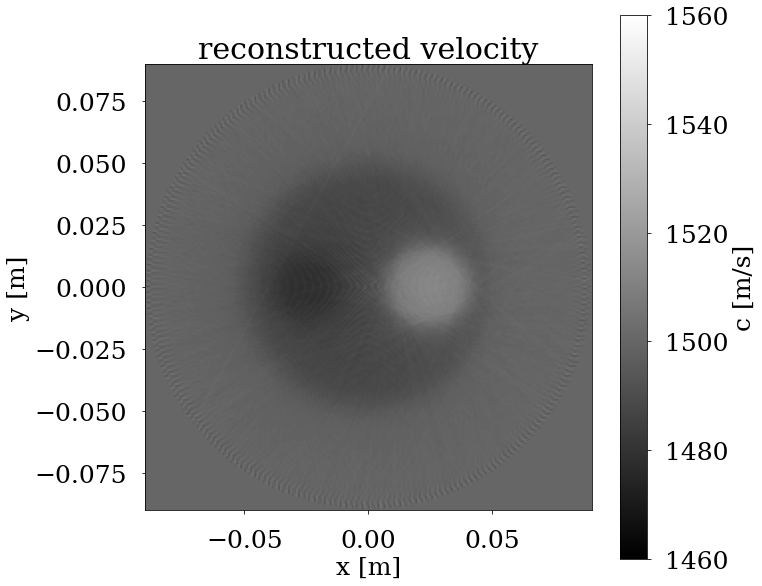

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.imshow(
    np.reshape(1 / m_rec_wf_dampedLS, [g.x.shape[0], g.y.shape[0]]).T,
    extent=[
        g.x[0],
        g.x[0] + g.x.shape[0] * g.spacing,
        g.y[0],
        g.y[0] + g.y.shape[0] * g.spacing,
    ],
    cmap="gray",
    vmin=1460,
    vmax=1560,
)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.colorbar(label="c [m/s]")
plt.title("reconstructed velocity")

## 4. Solve regularized least-squares Problem: **second order Tikhonov**

In this section, we implement a second order Tikhonov regularization, which solves:
$$\min_{\mathbf{m}}\frac{1}{2}||\mathbf{G}\mathbf{m}-\mathbf{d}||_2^2+\alpha||\nabla^2\mathbf{m}||^2_2.$$

We start again with an L-curve plot in order to determin the regularization weight.

In [15]:
def L_curve_tikh(L, G, d, reg_param, m_prior):
    x_values = np.zeros(len(reg_param))
    y_values = np.zeros(len(reg_param))
    for i in trange(len(reg_param)):
        Gtilde = scipy.sparse.vstack([G, reg_param[i] * L])
        zeros = np.zeros(G.shape[1])
        d_tilde = np.hstack([d, zeros])

        solution = scipy.sparse.linalg.lsmr(
            Gtilde, d_tilde, maxiter=600, show=False, damp=0.0, atol=1e-8
        )
        m_rec_wf = m_prior - solution[0]
        x_values[i] = np.linalg.norm(Gtilde.dot(m_rec_wf) - d_tilde)
        y_values[i] = np.linalg.norm(L.dot(m_rec_wf - m_prior))
    return x_values, y_values

In [16]:
### Define FD second order derivative matrix
Dsecond_order = scipy.sparse.diags(
    [1, 1, -4, 1, 1],
    [-int(np.sqrt(G.shape[1])), -1, 0, 1, int(np.sqrt(G.shape[1]))],
    shape=(G.shape[1], G.shape[1]),
)
reg_param = np.linspace(0.008, 0.3, 50)  # select a range of damping values to test
### for CI testing
b = 1
### to reproduce figures
# b = reg_param.shape[0]

x_values_tikh, y_values_tikh = L_curve_tikh(
    Dsecond_order, G, tof_shifts, reg_param[:b], m_prior
)

100%|██████████| 1/1 [00:30<00:00, 30.54s/it]


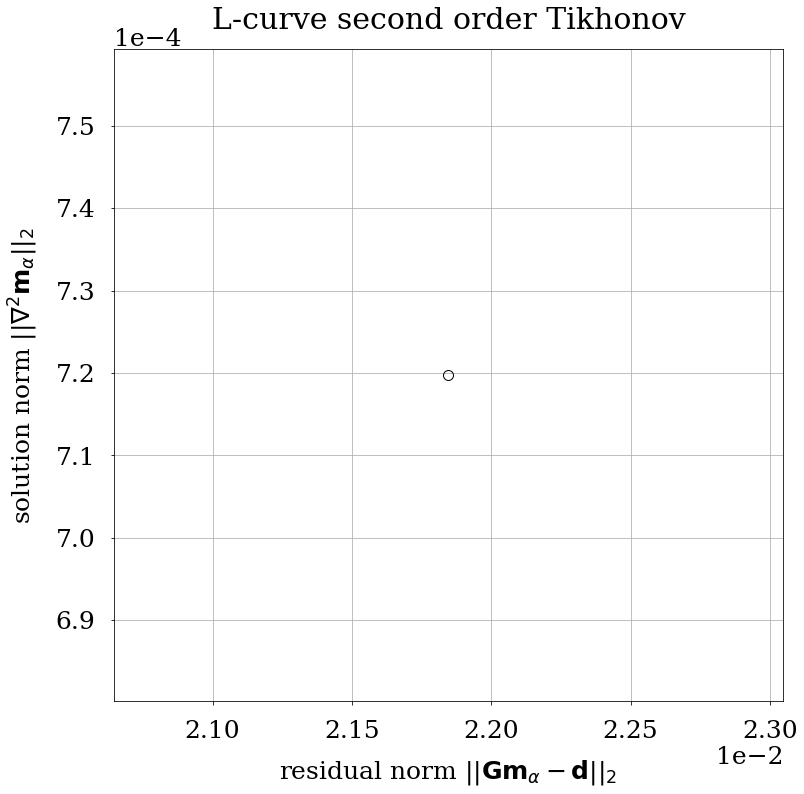

In [17]:
a = [2, 8, 12, 22]  # selected regularisation weigths are represented by colored dots
plot_Lcurve(
    x_values_tikh,
    y_values_tikh,
    reg_param,
    "L-curve second order Tikhonov",
    a,
    secondTikhonov=True,
)
# plt.savefig("../usct-interferometry/Analytical_Random_Wavefield/Phantom_experiments/Simulations/02_Analyticalphantom_RingSrcArray/figures/L-curve_2ndTikh.eps",bbox_inches="tight")

### 4.2 Invert for the phantom structure: **Second order Tikhonov**
Again, we make use of the above L-curve to select meaningful values for the regularization parameter $\alpha$

In [18]:
Gtilde = scipy.sparse.vstack([G, reg_param[23] * Dsecond_order])
zeros = np.zeros(G.shape[1])
tof_shifts_tilde = np.hstack([tof_shifts, zeros])

In [19]:
### second derivative ###
solution = linalg.lsmr(
    Gtilde, tof_shifts_tilde, maxiter=600, show=True, damp=0.0, atol=1e-8
)
m_rec_wf_tikh = m_prior - solution[0]

 
LSMR            Least-squares solution of  Ax = b

The matrix A has 116161 rows and 50625 columns
damp = 0.00000000000000e+00

atol = 1.00e-08                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      600

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  9.693e-05  1.169e-05   1.0e+00  1.2e+03
     1  0.00000e+00  8.575e-05  1.030e-05   8.8e-01  7.4e-01  1.6e-01  6.1e+00
     2  0.00000e+00  7.064e-05  8.088e-06   7.3e-01  1.3e-01  8.8e-01  2.9e+00
     3  0.00000e+00  5.978e-05  5.386e-06   6.2e-01  7.2e-02  1.3e+00  2.9e+00
     4  0.00000e+00  5.737e-05  4.298e-06   5.9e-01  5.1e-02  1.5e+00  2.9e+00
     5  0.00000e+00  5.644e-05  4.006e-06   5.8e-01  4.3e-02  1.7e+00  3.6e+00
     6  0.00000e+00  5.547e-05  3.877e-06   5.7e-01  3.8e-02  1.9e+00  5.9e+00
     7  0.00000e+00  5.348e-05  3.727e-06   5.5e-01  3.4e-02  2.1e+00  6.8e+00
     8  0.00000e+00  4.913e-05  3.447e-06   5.1e-01  3.2e-02  2.2e+00  5.3e+0

Text(0.5, 1.0, 'reconstructed velocity')

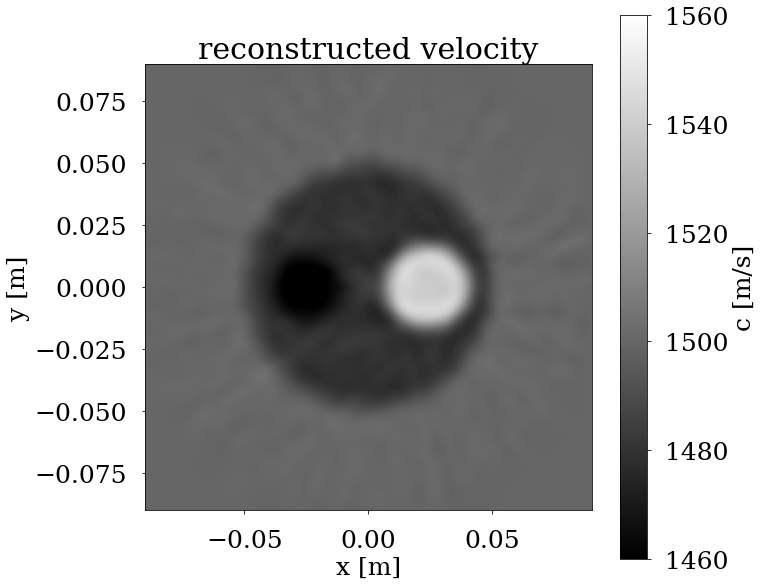

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.imshow(
    np.reshape(1 / m_rec_wf_tikh, [g.x.shape[0], g.y.shape[0]]).T,
    extent=[
        g.x[0],
        g.x[0] + g.x.shape[0] * g.spacing,
        g.y[0],
        g.y[0] + g.y.shape[0] * g.spacing,
    ],
    cmap="gray",
    vmin=1460,
    vmax=1560,
)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.colorbar(label="c [m/s]")
plt.title("reconstructed velocity")